In [3]:
!pip install datasets

In [4]:
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 19.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [5]:
from datasets import load_dataset

dataset_name = "bentrevett/multi30k"

dataset = load_dataset(dataset_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['en', 'de'],
        num_rows: 29000
    })
    validation: Dataset({
        features: ['en', 'de'],
        num_rows: 1014
    })
    test: Dataset({
        features: ['en', 'de'],
        num_rows: 1000
    })
})

In [7]:
import spacy

spacy_en = spacy.load('en_core_web_sm') # 영어 토큰화
spacy_de = spacy.load('de_core_news_sm') # 독일어 토큰화

In [66]:
# 토큰화 함수 정의
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

# 문장에 <sos>와 <eos> 토큰 추가 및 토큰화 함수 적용
def add_tokens(text):
    text['en'] = ['<sos>'] + tokenize_en(text['en'].lower()) + ['<eos>']
    text['de'] = ['<sos>'] + tokenize_de(text['de'].lower()) + ['<eos>']
    return text

# 각 데이터셋에 토큰화 함수 적용
tokenized_dataset = dataset.map(add_tokens)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [137]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import math
import torch.nn.functional as F

In [68]:
def text_to_indices(text, vocab):
    return [vocab[token] if token in vocab else vocab['<unk>'] for token in text]

class TranslationDataset(Dataset):
    def __init__(self, data, en_vocab, de_vocab, device):
        self.data = data
        self.en_vocab = en_vocab
        self.de_vocab = de_vocab
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        en_text = self.data[idx]['en']
        de_text = self.data[idx]['de']

        # 영어 문장 정수 인덱스 변환
        en_indices = text_to_indices(en_text, self.en_vocab)

        # 독일어 문장 정수 인덱스 변환
        de_indices = text_to_indices(de_text, self.de_vocab)

        #return {'en': en_indices, 'de': de_indices}
        return {'en': torch.tensor(en_indices).to(self.device),
                'de': torch.tensor(de_indices).to(self.device)}

en_vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}
de_vocab = {'<unk>': 0, '<pad>': 1, '<sos>': 2, '<eos>': 3}

en_token_counts = {}
de_token_counts = {}

for text in tokenized_dataset['train']:
    for token in text['en']:
        if token not in en_token_counts:
            en_token_counts[token] = 0
        en_token_counts[token] += 1

    for token in text['de']:
        if token not in de_token_counts:
            de_token_counts[token] = 0
        de_token_counts[token] += 1

for token, count in en_token_counts.items():
    if count >= 2 and token not in en_vocab:
        en_vocab[token] = len(en_vocab)

for token, count in de_token_counts.items():
    if count >= 2 and token not in de_vocab:
        de_vocab[token] = len(de_vocab)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = TranslationDataset(tokenized_dataset['train'], en_vocab, de_vocab, device)
valid_dataset = TranslationDataset(tokenized_dataset['validation'], en_vocab, de_vocab, device)
test_dataset = TranslationDataset(tokenized_dataset['test'], en_vocab, de_vocab, device)

# DataLoader 생성
batch_size = 64

def collate_fn(batch):
    src_batch = [text['de'] for text in batch]
    trg_batch = [text['en'] for text in batch]

    src_padded = pad_sequence(src_batch, batch_first=True, padding_value=en_vocab['<pad>'])
    trg_padded = pad_sequence(trg_batch, batch_first=True, padding_value=de_vocab['<pad>'])

    return {'src': src_padded, 'trg': trg_padded}

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, drop_last=True)

In [69]:
print(len(de_vocab), len(en_vocab))

7853 5893


In [70]:
for i, batch in enumerate(train_loader):
    src = batch['src']
    trg = batch['trg']

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [seq_num, seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([64, 22])
인덱스 0: 2
인덱스 1: 21
인덱스 2: 328
인덱스 3: 2081
인덱스 4: 194
인덱스 5: 33
인덱스 6: 29
인덱스 7: 0
인덱스 8: 16
인덱스 9: 3
인덱스 10: 1
인덱스 11: 1
인덱스 12: 1
인덱스 13: 1
인덱스 14: 1
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1


In [119]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = hidden_dim // n_heads

        self.fc_q = nn.Linear(hidden_dim, hidden_dim)
        self.fc_k = nn.Linear(hidden_dim, hidden_dim)
        self.fc_v = nn.Linear(hidden_dim, hidden_dim)

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        if mask is not None:
            energy = energy.masked_fill(mask==0, -1e10)

        attention = torch.softmax(energy, dim=-1) # head_dim 차원에 softmax 적용 => attention score를 정규화

        x = torch.matmul(self.dropout(attention), V)

        x = x.permute(0, 2, 1, 3).contiguous()  # 연속적인 메모리로 재배열 (view 함수 쓰기 전 사용 필요)

        x = x.view(batch_size, -1, self.hidden_dim)

        x = self.fc_o(x)

        return x, attention

In [213]:
class FeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, ff_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, ff_dim)
        self.fc_2 = nn.Linear(ff_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        x = self.dropout(torch.relu(self.fc_1(x)))

        x = self.fc_2(x)

        return x

In [214]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device):
        super().__init__()

        self.attn_layer_norm = nn.LayerNorm(hidden_dim) # hidden_dim 차원 정규화
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
        self.feedforward = FeedforwardLayer(hidden_dim, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, src_mask):
        _src, attention = self.self_attention(src, src, src, src_mask)

        src = self.attn_layer_norm(src+self.dropout(_src))

        _src = self.feedforward(src)

        src = self.ff_layer_norm(src+self.dropout(_src))

        return src

In [215]:
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_dim, device):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.device = device

    def forward(self, src):

        batch_size, src_len = src.shape[0], src.shape[1]
        pe = torch.zeros(src_len, self.hidden_dim).to(self.device)
        position = torch.arange(0, src_len).unsqueeze(1).to(self.device)
        div_term = torch.exp(torch.arange(0, self.hidden_dim, 2) * -(math.log(10000.0)/self.hidden_dim)).to(self.device)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).expand(batch_size, src_len, self.hidden_dim)

        return pe

In [216]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device, input_dim, n_layers):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = PositionalEncoding(hidden_dim, device)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, ff_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        src = self.dropout(self.tok_embedding(src)*self.scale + self.pos_embedding(src))

        for layer in self.layers:
            src = layer(src, src_mask)

        return src

In [217]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device):
        super().__init__()

        self.attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)

        self.self_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttention(hidden_dim, n_heads, dropout_ratio, device)
        self.feedforward = FeedforwardLayer(hidden_dim, ff_dim, dropout_ratio)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src, trg, src_mask, trg_mask):

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.attn_layer_norm(self.dropout(_trg) + trg)

        _trg, _ = self.encoder_attention(trg, src, src, src_mask)
        trg = self.enc_attn_layer_norm(self.dropout(_trg) + trg)

        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(self.feedforward(_trg) + trg)

        return trg

In [218]:
class Decoder(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, dropout_ratio, device, output_dim, n_layers):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = PositionalEncoding(hidden_dim, device)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, ff_dim, dropout_ratio, device) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)
        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, trg, src_mask, trg_mask):

        trg = self.dropout(self.tok_embedding(trg)*self.scale + self.pos_embedding(trg))

        for layer in self.layers:
            trg = layer(src, trg, src_mask, trg_mask)

        output = self.fc_out(trg)

        return output

In [219]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        return src_mask

    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask

        return trg_mask

    def forward(self, src, trg):

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        src = self.encoder(src, src_mask)
        output = self.decoder(src, trg, src_mask, trg_mask)

        return output

In [220]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
hidden_dim = 512
n_layers = 3
n_heads = 8
ff_dim = 512
dropout = 0.1

In [221]:
src_pad_idx = de_vocab['<pad>']
trg_pad_idx = en_vocab['<pad>']

encoder = Encoder(hidden_dim, n_heads, ff_dim, dropout, device, input_dim, n_layers)
decoder = Decoder(hidden_dim, n_heads, ff_dim, dropout, device, output_dim, n_layers)

model = Transformer(encoder, decoder, src_pad_idx, trg_pad_idx, device).to(device)

In [222]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,683,909 trainable parameters


In [223]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(7853, 512)
    (pos_embedding): PositionalEncoding()
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttention(
          (fc_q): Linear(in_features=512, out_features=512, bias=True)
          (fc_k): Linear(in_features=512, out_features=512, bias=True)
          (fc_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_o): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): FeedforwardLayer(
          (fc_1): Linear(in_features=512, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=

In [224]:
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup

optimizer = optim.AdamW(model.parameters(), lr=0.0005)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = trg_pad_idx)
total_steps = len(train_loader) * 15
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1400,
    num_training_steps=total_steps
)

In [225]:
def train(model, iterator, optimizer, criterion, epoch, scheduler):
    model.train()
    epoch_loss = 0

    for i, batch in enumerate(tqdm(iterator, desc=f"Train Epoch {epoch+1}")):
        src = batch['src']
        trg = batch['trg']

        optimizer.zero_grad()

        output = model(src, trg[:, :-1])

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output, trg)
        loss.backward()

        optimizer.step()
        scheduler.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [226]:
def evaluate(model, iterator, criterion, epoch):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator, desc=f"Valid Epoch {epoch+1}")):

            src = batch['src']
            trg = batch['trg']

            output = model(src, trg[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)

            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [227]:
epochs = 15
clip = 1
best_valid_loss = float('inf')
model_save_path = "/content/drive/MyDrive/IIPL Lab/Intern/7주차. Transformer_german_to_english.pt"

train_losses = []
valid_losses = []

for epoch in range(epochs):

    train_loss = train(model, train_loader, optimizer, criterion, epoch, scheduler)
    valid_loss = evaluate(model, valid_loader, criterion, epoch)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'Train Loss: {train_loss:.4f}, Validation Loss: {valid_loss:.4f}')

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved!")

Valid Epoch 1: 100%|██████████| 15/15 [00:00<00:00, 25.92it/s]


Train Loss: 5.3578, Validation Loss: 3.6601
Best model saved!


Valid Epoch 2: 100%|██████████| 15/15 [00:00<00:00, 26.01it/s]


Train Loss: 3.1731, Validation Loss: 2.3995
Best model saved!


Valid Epoch 3: 100%|██████████| 15/15 [00:00<00:00, 25.65it/s]


Train Loss: 2.2900, Validation Loss: 1.9512
Best model saved!


Valid Epoch 4: 100%|██████████| 15/15 [00:00<00:00, 25.91it/s]


Train Loss: 1.8375, Validation Loss: 1.7255
Best model saved!


Valid Epoch 5: 100%|██████████| 15/15 [00:00<00:00, 25.57it/s]


Train Loss: 1.5091, Validation Loss: 1.6184
Best model saved!


Valid Epoch 6: 100%|██████████| 15/15 [00:00<00:00, 25.52it/s]


Train Loss: 1.2810, Validation Loss: 1.5759
Best model saved!


Valid Epoch 7: 100%|██████████| 15/15 [00:00<00:00, 25.74it/s]


Train Loss: 1.1059, Validation Loss: 1.5401
Best model saved!


Valid Epoch 8: 100%|██████████| 15/15 [00:00<00:00, 25.98it/s]


Train Loss: 0.9575, Validation Loss: 1.5535


Valid Epoch 9: 100%|██████████| 15/15 [00:00<00:00, 22.15it/s]


Train Loss: 0.8330, Validation Loss: 1.5664


Valid Epoch 10: 100%|██████████| 15/15 [00:00<00:00, 19.44it/s]


Train Loss: 0.7190, Validation Loss: 1.5745


Valid Epoch 11: 100%|██████████| 15/15 [00:00<00:00, 20.73it/s]


Train Loss: 0.6216, Validation Loss: 1.6061


Valid Epoch 12: 100%|██████████| 15/15 [00:00<00:00, 19.98it/s]


Train Loss: 0.5358, Validation Loss: 1.6325


Valid Epoch 13: 100%|██████████| 15/15 [00:00<00:00, 25.18it/s]


Train Loss: 0.4646, Validation Loss: 1.6568


Valid Epoch 14: 100%|██████████| 15/15 [00:00<00:00, 25.92it/s]


Train Loss: 0.4059, Validation Loss: 1.6725


Valid Epoch 15: 100%|██████████| 15/15 [00:00<00:00, 25.75it/s]

Train Loss: 0.3626, Validation Loss: 1.6808


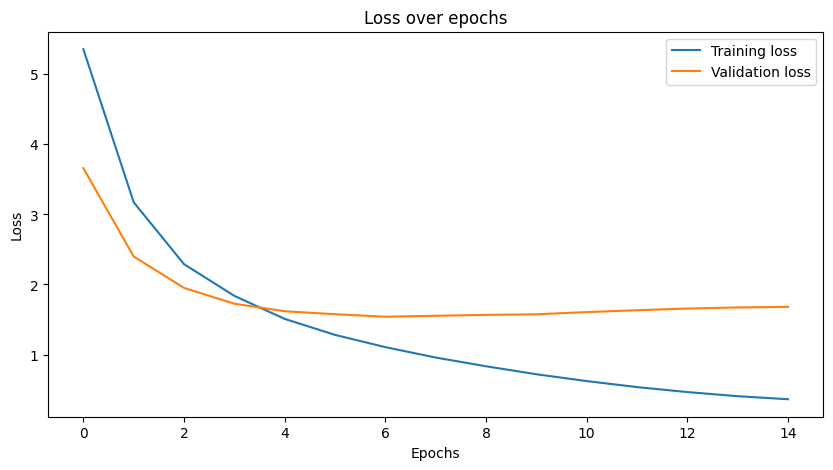

In [228]:
import matplotlib.pyplot as plt

def plot_loss(train_losses, valid_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training loss')
    plt.plot(valid_losses, label='Validation loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_losses, valid_losses)

In [229]:
def test(model, iterator, criterion):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)):

            src = batch['src']
            trg = batch['trg']

            output = model(src, trg[:,:-1])

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)

            trg = trg[:,1:].contiguous().view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [230]:
model_save_path = "/content/drive/MyDrive/IIPL Lab/Intern/7주차. Transformer_german_to_english.pt"

model.load_state_dict(torch.load(model_save_path))

test_loss = test(model, test_loader, criterion)

print(f'Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}')

100%|██████████| 15/15 [00:00<00:00, 26.65it/s]

Test Loss: 1.586 | Test PPL: 4.885


In [231]:
# 번역(translation) 함수
def translate_sentence(sentence, model, device, max_len=50):
    model.eval() # 평가 모드

    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    src_indexes = [de_vocab[token] if token in de_vocab else de_vocab['<unk>'] for token in tokens]

    src_tensor = torch.tensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 출력 값 구하기
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [en_vocab['<sos>']]

    for i in range(max_len):

        trg_tensor = torch.tensor(trg_indexes).unsqueeze(0).to(device)
        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output = model.decoder(enc_src, trg_tensor, src_mask, trg_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기
        # <eos>를 만나는 순간 끝
        if pred_token == de_vocab['<eos>']:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [list(en_vocab.keys())[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:]

In [232]:
example_idx = 10

src = tokenized_dataset['test']['de'][example_idx]
trg = tokenized_dataset['test']['en'][example_idx]

print(f'소스 문장: {src}')
print(f'타겟 문장: {trg}')

translation = translate_sentence(src, model, device)

print("모델 출력 결과:", translation)

소스 문장: ['<sos>', 'eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.', '<eos>']
타겟 문장: ['<sos>', 'a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']
모델 출력 결과: ['a', 'mother', 'and', 'her', 'little', 'son', 'enjoy', 'a', 'nice', 'day', 'outdoors', '.', '<eos>']


In [233]:
from torchtext.data.metrics import bleu_score

def show_bleu(data, model, device, max_len=50):
    trgs = []
    pred_trgs = []
    index = 0

    for datum in tqdm(data):
        src = datum['de']
        trg = datum['en']

        pred_trg = translate_sentence(src, model, device, max_len)

        # 마지막 <eos> 토큰 제거
        pred_trg = pred_trg[:-1]

        pred_trgs.append(pred_trg)
        trg_tokens = trg[1:-1]
        trgs.append([trg_tokens])

        index += 1
        if (index + 1) % 100 == 0:
            print(f"[{index + 1}/{len(data)}]")
            print(f"예측: {pred_trg}")
            print(f"정답: {trg_tokens}")

    bleu = bleu_score(pred_trgs, trgs, max_n=4, weights=[0.25, 0.25, 0.25, 0.25])
    print(f'Total BLEU Score = {bleu*100:.2f}')

    individual_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    individual_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 1, 0, 0])
    individual_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 1, 0])
    individual_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[0, 0, 0, 1])

    print(f"Multiple Sentence score1 = {individual_bleu1_score*100:.2f}")
    print(f"Multiple Sentence score2 = {individual_bleu2_score*100:.2f}")
    print(f"Multiple Sentence score3 = {individual_bleu3_score*100:.2f}")
    print(f"Multiple Sentence score4 = {individual_bleu4_score*100:.2f}")

    cumulative_bleu1_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1, 0, 0, 0])
    cumulative_bleu2_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/2, 1/2, 0, 0])
    cumulative_bleu3_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/3, 1/3, 1/3, 0])
    cumulative_bleu4_score = bleu_score(pred_trgs, trgs, max_n=4, weights=[1/4, 1/4, 1/4, 1/4])

    print(f'Cumulative BLEU1 score = {cumulative_bleu1_score*100:.2f}')
    print(f'Cumulative BLEU2 score = {cumulative_bleu2_score*100:.2f}')
    print(f'Cumulative BLEU3 score = {cumulative_bleu3_score*100:.2f}')
    print(f'Cumulative BLEU4 score = {cumulative_bleu4_score*100:.2f}')

In [234]:
show_bleu(tokenized_dataset['test'], model, device)

 10%|█         | 101/1000 [00:07<01:01, 14.58it/s]

[100/1000]
예측: ['a', 'group', 'of', 'mostly', 'children', 'sit', 'in', '<unk>', 'on', 'blue', 'chairs', '.']
정답: ['a', 'group', 'of', 'mostly', 'asian', 'children', 'sitting', 'at', 'cubicles', 'in', 'blue', 'chairs', '.']


 20%|██        | 201/1000 [00:14<00:51, 15.44it/s]

[200/1000]
예측: ['all', 'people', 'are', 'standing', 'under', 'umbrellas', '.']
정답: ['the', 'group', 'of', 'people', 'are', 'all', 'covered', 'by', 'umbrellas', '.']


 30%|███       | 302/1000 [00:20<00:39, 17.55it/s]

[300/1000]
예측: ['a', 'goalie', 'in', 'a', 'yellow', 'uniform', 'is', 'unpacking', 'the', 'goal', '.']
정답: ['a', 'goalie', 'in', 'a', 'yellow', 'field', 'is', 'protecting', 'the', 'goal', '.']


 40%|████      | 401/1000 [00:27<00:31, 18.77it/s]

[400/1000]
예측: ['two', 'young', 'children', 'are', 'on', 'sand', '.']
정답: ['two', 'young', 'children', 'are', 'on', 'sand', '.']


 50%|█████     | 500/1000 [00:33<00:29, 16.72it/s]

[500/1000]
예측: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']
정답: ['two', 'medium', 'sized', 'dogs', 'run', 'across', 'the', 'snow', '.']


 60%|██████    | 602/1000 [00:41<00:25, 15.57it/s]

[600/1000]
예측: ['a', 'group', 'of', 'men', 'sit', 'and', 'talk', 'behind', 'green', 'pots', '.']
정답: ['a', 'group', 'of', 'men', 'sitting', 'and', 'talking', 'behind', 'some', 'green', 'fruit', '.']


 70%|███████   | 701/1000 [00:48<00:22, 13.30it/s]

[700/1000]
예측: ['two', 'people', 'are', 'looking', 'at', 'the', 'lights', 'in', 'a', 'city', '.']
정답: ['two', 'people', 'look', 'on', 'in', 'the', 'nighttime', 'at', 'the', 'lights', 'in', 'a', 'city', '.']


 80%|████████  | 802/1000 [00:55<00:12, 15.47it/s]

[800/1000]
예측: ['<unk>', 'is', 'riding', 'bike', '.']
정답: ['crowds', 'of', 'people', 'are', 'all', 'riding', 'bicycles', '.']


 90%|█████████ | 900/1000 [01:02<00:09, 10.98it/s]

[900/1000]
예측: ['children', 'are', 'fighting', 'over', 'possession', 'of', 'the', 'ball', '.']
정답: ['kids', 'compete', 'to', 'gain', 'possession', 'of', 'the', 'soccer', 'ball', '.']


100%|██████████| 1000/1000 [01:10<00:00, 14.21it/s]


[1000/1000]
예측: ['an', 'older', 'man', 'playing', 'a', 'video', 'game', '.']
정답: ['an', 'older', 'man', 'is', 'playing', 'a', 'video', 'arcade', 'game', '.']
Total BLEU Score = 37.76
Multiple Sentence score1 = 68.53
Multiple Sentence score2 = 45.32
Multiple Sentence score3 = 30.68
Multiple Sentence score4 = 21.34
Cumulative BLEU1 score = 68.53
Cumulative BLEU2 score = 55.73
Cumulative BLEU3 score = 45.68
Cumulative BLEU4 score = 37.76
